In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame, Series
from dslabs_functions import select_redundant_variables, get_variable_types, encode_cyclic_variables, dummify, mvi_by_filling, evaluate_approach, plot_multibar_chart, determine_outlier_thresholds_for_var, set_chart_labels, study_variance_for_feature_selection, study_redundancy_for_feature_selection, HEIGHT, select_low_variance_variables
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from imblearn.over_sampling import SMOTE
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, read_train_test_from_files
from dslabs_functions import plot_evaluation_results, plot_multiline_chart
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from typing import Literal
from subprocess import call
from sklearn.tree import plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

In [2]:
# Lire les données
train: DataFrame = read_csv("datasets/class_pos_covid_train.csv", index_col="Unnamed: 0", na_values=None)
test: DataFrame = read_csv("datasets/class_pos_covid_test.csv", index_col="Unnamed: 0", na_values=None)

In [3]:
def gradient_boosting_study(
    trnX: np.ndarray,
    trnY: np.array,
    tstX: np.ndarray,
    tstY: np.array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[GradientBoostingClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    learning_rates: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: GradientBoostingClassifier | None = None
    best_params: dict = {"name": "GB", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    cols: int = len(max_depths)
    _, axs = plt.subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for lr in learning_rates:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = GradientBoostingClassifier(
                    n_estimators=n, max_depth=d, learning_rate=lr
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, lr, n)
                    best_model = clf
                # print(f'GB d={d} lr={lr} n={n}')
            values[lr] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Gradient Boosting with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'GB best for {best_params["params"][2]} trees (d={best_params["params"][0]} and lr={best_params["params"][1]}'
    )

    return best_model, best_params

def read_train_test_from_files_2(
    train_fn: str, test_fn: str, target: str = "class"
) -> tuple[np.ndarray, np.ndarray, np.array, np.array, list, list]:
    train: DataFrame = read_csv(train_fn, index_col="Unnamed: 0", na_values=None)
    labels: list = list(train[target].unique())
    labels.sort()
    trnY: np.array = train.pop(target).to_list()
    trnX: np.ndarray = train.values

    test: DataFrame = read_csv(test_fn, index_col="Unnamed: 0", na_values=None)
    tstY: np.array = test.pop(target).to_list()
    tstX: np.ndarray = test.values
    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()


Train#=432120 Test#=76187
Labels=[0.0, 1.0]
GB best for 500 trees (d=7 and lr=0.9


<Figure size 600x450 with 0 Axes>

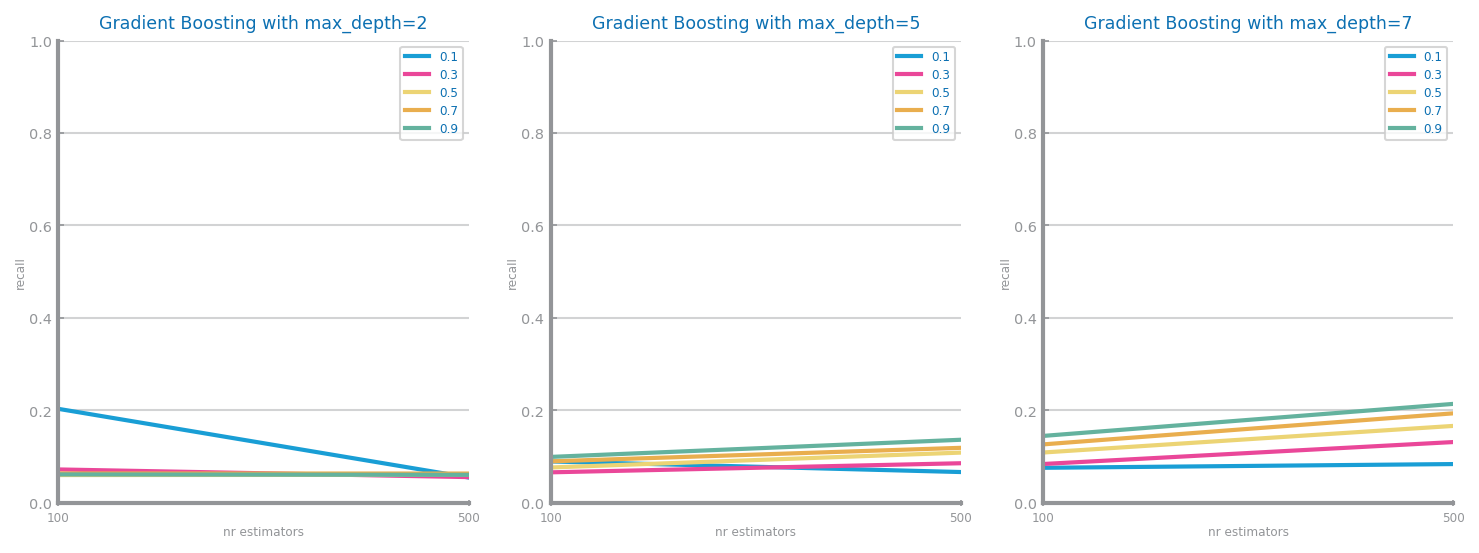

In [4]:
file_tag='class_pos_covid'
train_filename = "datasets/class_pos_covid_train.csv"
test_filename = "datasets/class_pos_covid_test.csv"
target = 'CovidPos'
eval_metric = "recall"

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files_2(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

plt.figure()
best_model, params = gradient_boosting_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=500,
    lag=250,
    metric=eval_metric,
)
plt.savefig(f"images/{file_tag}_gb_{eval_metric}_study.png")
plt.show()

<Figure size 600x450 with 0 Axes>

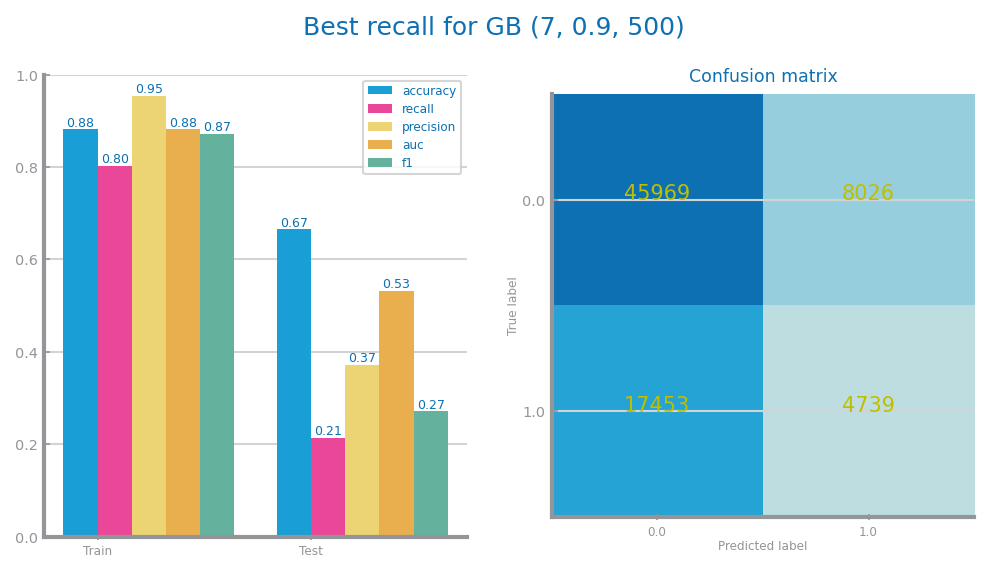

In [5]:
prd_trn: np.array = best_model.predict(trnX)
prd_tst: np.array = best_model.predict(tstX)
plt.figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
plt.savefig(f'images/{file_tag}_gb_{params["name"]}_best_{params["metric"]}_eval.png')
plt.show()

1. AgeCategory (0.4617963767835156)
2. SmokerStatus (0.12460931812692083)
3. RemovedTeeth (0.07478210230345717)
4. SleepHours (0.05882243784404289)
5. TetanusLast10Tdap (0.05818020352483149)
6. HeightInMeters (0.052093379968843063)
7. GeneralHealth (0.04099604914961177)
8. HadDiabetes (0.009650024482437312)
9. ChestScan (0.00949814732392622)
10. FluVaxLast12 (0.007887875677561251)
11. AlcoholDrinkers (0.007707795415017266)
12. Sex (0.007066975446156274)
13. HadArthritis (0.0064800550421129375)
14. HIVTesting (0.006231811845305344)
15. HadAsthma (0.0058175341832744955)
16. PhysicalActivities (0.005653690200531606)
17. HadDepressiveDisorder (0.005408800171286953)
18. PneumoVaxEver (0.005291818313203409)
19. DifficultyConcentrating (0.004713310344165963)
20. RaceEthnicityCategory_Hispanic (0.004423857541565079)
21. HadCOPD (0.004183617839218155)
22. DeafOrHardOfHearing (0.004129594729775114)
23. DifficultyWalking (0.004067244227553888)
24. RaceEthnicityCategory_Other race only, Non-Hispan

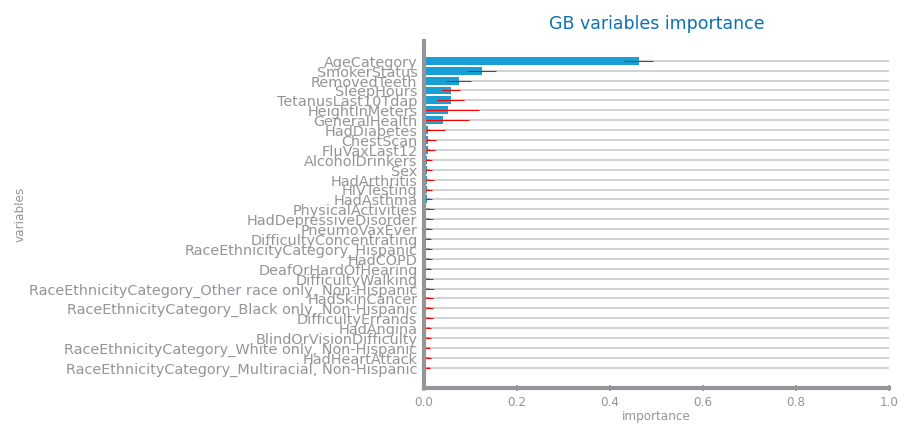

In [6]:
trees_importances: list[float] = []
for lst_trees in best_model.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(std(trees_importances, axis=0))
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

plt.figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="GB variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
plt.savefig(f"images/{file_tag}_gb_{eval_metric}_vars_ranking.png")


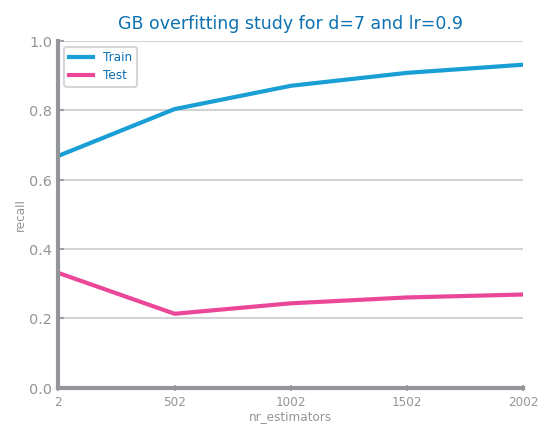

In [7]:

d_max: int = params["params"][0]
lr: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "recall"

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: np.array = clf.predict(tstX)
    prd_trn_Y: np.array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

plt.figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"GB overfitting study for d={d_max} and lr={lr}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
plt.savefig(f"images/{file_tag}_gb_{eval_metric}_overfitting.png")

